# Introduction/ Business Problem

This final project explores the neighborhoods of Seattle, WA in hopes of locating the optimal locations to live that supports dog ownership. The city of Seattle is a popular location to live for both the lively city life and for career opportunities, but it is a large city of 127 neighborhoods and that can pose problems as to deciding where to live for those that own a dog. Dog ownership is often times more time and resource intensive than cat ownership as they need to go on walks and need other living requirements met, presenting the problem of finding resources nearby like pet shops, dog parks, and dog daycares among other commonly sought after resources. There are many neighborhoods to choose from in Seattle and each area offers different benefits, so it can be a daunting task to find a location that is optimal for dog ownership.

# Data

The data used in this project will come from three primary sources to obtain data on Seattle neighborhoods, geolocation data, and venue data. 
The raw data on Seattle neighborhoods will be obtained from wikipedia at the following link: "https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle". 
The geolocation data for the neighborhoods will be obtained with geopy geocoders package. 
Finally, the venue data will be obtained using the foursquare API.

# Methodology

In this project, a large part of the dataset cleaning is performed through the python package Pandas. The table from the wikipedia link is scraped and read as a raw dataframe using pandas as well as the subsequent cleaning of the data to get a workable dataset. 

Requests for location data for each neighborhood in my dataset were made through the Geopy server through the Nominatim service. 

Folium is used to generate a map of Seattle to visualize neighborhood locations as well as visualizing the clustermaps that will be created. 

The get requests for venues of each neighborhood will be obtained through the Foursquare API and one hot encoding will be used on the venue data to be used with the KMeans clustering algorithm.

The optimal clustering will decided by using the elbow curve method on my dataset. 

Finally, the unsupervized machine learning KMeans clustering algorithm will be run on the dataset and the resulting clusters will be visualized with folium to create a map of the clusters. 

### Library Package Import

In [1]:
import pandas as pd
import numpy as np
import json
import requests
from pandas.io.json import json_normalize
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
#!conda install -c conda-forge folium=0.5.0 --yes
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

### Getting the list of neighborhoods in Seattle before cleaning

In [2]:
link = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle'
raw_neighborhoods = pd.read_html(link, header=0) [0]
raw_neighborhoods.head(20)

,Unnamed: 0,Neighborhood name,Within larger district,Annexed[41],Locator map,Street map,Image,Notes
0,1,North Seattle,Seattle,Various,NaN,NaN,NaN,North of the Lake Washington Ship Canal[42]
1,2,Broadview,North Seattle[42],1954[43],NaN,NaN,NaN,[44]
2,3,Bitter Lake,North Seattle[42],1954[43],NaN,NaN,NaN,[45]
3,4,North Beach / Blue Ridge,North Seattle[42],"1940,[43] 1954[43]",NaN,NaN,NaN,[46]
4,5,Crown Hill,North Seattle[42],"1907,[47] 1952,[43] 1954[43]",NaN,NaN,NaN,[48]
5,6,Greenwood,North Seattle[42],"1891,[43] 1954[43]",NaN,NaN,NaN,[49]
6,7,Northgate,North Seattle[42],various 1891-1954[43],NaN,NaN,NaN,[50]
7,8,Haller Lake,Northgate[50],1954[43],NaN,NaN,NaN,[51]
8,9,Pinehurst,Northgate[50],1953[43],NaN,NaN,NaN,[52]
9,10,North College Park (Licton Springs),Northgate[50],"1950, 1954[43]",NaN,NaN,NaN,[53]


### Dataset cleaning

In [3]:
clean_neigh = raw_neighborhoods.drop(['Unnamed: 0','Within larger district','Annexed[41]','Locator map','Street map','Image','Notes'], axis=1)
clean_neigh.drop_duplicates(inplace=True)
print(clean_neigh.head())
print(clean_neigh.shape)

          Neighborhood name
0             North Seattle
1                 Broadview
2               Bitter Lake
3  North Beach / Blue Ridge
4                Crown Hill
(127, 1)


In [4]:
clean_neigh.to_csv('clean_neigh.csv', index=False)

In [5]:
#editing neighborhood entries that are spelt incorrectly or refer to two areas
clean_neigh.at[17,'Neighborhood name'] = 'Wedgewood'
clean_neigh.at[26,'Neighborhood name'] = 'University District'
clean_neigh.at[51,'Neighborhood name'] = 'Portage Bay'
clean_neigh.at[62,'Neighborhood name'] = 'South Lake Union'
clean_neigh.at[73,'Neighborhood name'] = 'International District'
clean_neigh.at[76,'Neighborhood name'] = 'West Edge'
clean_neigh.at[77,'Neighborhood name'] = 'Central District'
clean_neigh.at[85,'Neighborhood name'] = 'Denny-Blaine'
clean_neigh.at[94,'Neighborhood name'] = 'Othello'
clean_neigh.at[95,'Neighborhood name'] = 'Rainier Beach'

In [6]:
#Dropping neighborhoods that can't be easily found with Geopy
clean_neigh.drop(index=[3,9,43,46,47,48,49,53,63,67,69,70,80,85,87,96,100,101,102,103,111,112,113], inplace=True)
clean_neigh.shape

(104, 1)

In [7]:
neighborhoods = clean_neigh
neighborhoods

,Neighborhood name
0,North Seattle
1,Broadview
2,Bitter Lake
4,Crown Hill
5,Greenwood
6,Northgate
7,Haller Lake
8,Pinehurst
10,Maple Leaf
11,Lake City


## Adding geographical coordinates of neighborhoods

GeoPY API

In [8]:
geolocator = Nominatim(user_agent ="seattle_explorer")
for i in range (0,104):
    try:
            address = '{}, Seattle, WA'.format(neighborhoods.iloc[i,0])
            location = geolocator.geocode(address)
            lats = location.latitude
            longs = location.longitude
            neighborhoods = neighborhoods.append({'Neighborhood':"{}".format(neighborhoods.iloc[i,0]),'Latitude':lats, 'Longitude':longs}, ignore_index=True)
    except:
        pass
    
print('Neighborhoods geocoded!')
neighborhoods

Neighborhoods geocoded!


,Neighborhood name,Latitude,Longitude,Neighborhood
0,North Seattle,NaN,NaN,NaN
1,Broadview,NaN,NaN,NaN
2,Bitter Lake,NaN,NaN,NaN
3,Crown Hill,NaN,NaN,NaN
4,Greenwood,NaN,NaN,NaN
5,Northgate,NaN,NaN,NaN
6,Haller Lake,NaN,NaN,NaN
7,Pinehurst,NaN,NaN,NaN
8,Maple Leaf,NaN,NaN,NaN
9,Lake City,NaN,NaN,NaN


In [43]:
#Dataframe resulted in adding to the bottom, so cleaning is necessary
cleaned_neighborhoods= neighborhoods.drop(['Neighborhood name'], axis = 1)
cleaned_neighborhoods.dropna(inplace=True)
cleaned_neighborhoods.reset_index(drop=True,inplace=True)
cleaned_neighborhoods
#Dataset cleaned and geocoordinates added

,Latitude,Longitude,Neighborhood
104,47.660773,-122.291497,North Seattle
105,47.722320,-122.360407,Broadview
106,47.726236,-122.348764,Bitter Lake
107,47.694715,-122.371459,Crown Hill
108,47.690981,-122.354877,Greenwood
109,47.713153,-122.321231,Northgate
110,47.719748,-122.333751,Haller Lake
111,47.603832,-122.330062,Pinehurst
112,47.693987,-122.322905,Maple Leaf
113,47.719162,-122.295494,Lake City


In [46]:
#making a csv to look through
cleaned_neighborhoods.to_csv('cleaned_neighborhoods.csv', index=False)

## Seattle geolocation

In [48]:
address = 'Seattle, WA'

geolocator = Nominatim(user_agent ="seattle_explorer")
location = geolocator.geocode(address)
sea_latitude = location.latitude
sea_longitude = location.longitude
print('The geographical coordinates of Seattle are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Seattle are 47.6038321, -122.3300624.


### Making a map of seattle in Folium

In [49]:
#Initialize map
seattle_map= folium.Map(location=[sea_latitude, sea_longitude], zoom_start = 10)

#add markers to map
for lat, lng, label in zip(cleaned_neighborhoods['Latitude'],cleaned_neighborhoods['Longitude'],cleaned_neighborhoods['Neighborhood']):
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.5,
    parse_html=False).add_to(seattle_map)
seattle_map

### Foursquare credentials

In [78]:
Client_ID= 'KB2S1BKW2PN2ILKDGKM0GABJUSQZD1KDNOR3NXMNHYSTZSR0'
Client_Secret='VY5Z3DKC0CXEINWMEUEVPIFEQGLYRNAMA02DRABS55PPQ4ZA'
Version= '20180604'
Radius = 500
LIMIT = 100
Query = 'pet'

### Define some functions

In [79]:
def getNearbyVenues(names, latitudes, longitudes, Radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},&radius={}&limit={}'.format(
            Client_ID, 
            Client_Secret, 
            Version, 
            lat, 
            lng,
            Radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [88]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [80]:
seattle_df = cleaned_neighborhoods
seattle_venues = getNearbyVenues(names=seattle_df['Neighborhood'],latitudes=seattle_df['Latitude'],longitudes=seattle_df['Longitude'],Radius=Radius)

North Seattle


KeyError: 'groups'

In [83]:
seattle_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North Seattle,47.660773,-122.291497,Burke-Gilman Brewing Company,47.661308,-122.288067,Brewery
1,North Seattle,47.660773,-122.291497,Jak's Grill,47.661072,-122.288073,Steakhouse
2,North Seattle,47.660773,-122.291497,Center for Urban Horticulture,47.657978,-122.290237,College Science Building
3,North Seattle,47.660773,-122.291497,Burgermaster,47.661561,-122.293952,Burger Joint
4,North Seattle,47.660773,-122.291497,Baskin-Robbins,47.661336,-122.292004,Ice Cream Shop
5,North Seattle,47.660773,-122.291497,General Porpoise Coffee & Donuts,47.662317,-122.293294,Donut Shop
6,North Seattle,47.660773,-122.291497,The Seattle Gym,47.661273,-122.286642,Gym
7,North Seattle,47.660773,-122.291497,Varlamos Pizzeria,47.660962,-122.288447,Pizza Place
8,North Seattle,47.660773,-122.291497,El Camion,47.661769,-122.286903,Food Truck
9,North Seattle,47.660773,-122.291497,Great State Burger,47.661219,-122.288488,Burger Joint


In [75]:
seattle_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adams,5,5,5,5,5,5
Alki Point,5,5,5,5,5,5
Arbor Heights,2,2,2,2,2,2
Atlantic,12,12,12,12,12,12
Ballard,9,9,9,9,9,9
Beacon Hill,17,17,17,17,17,17
Belltown,84,84,84,84,84,84
Bitter Lake,26,26,26,26,26,26
Briarcliff,4,4,4,4,4,4


In [89]:
#creating a csv for the venues
seattle_venues.to_csv('venues.csv', index=False)

### How many unique venues?

In [64]:
print('There are {} unique venue categories'.format(len(seattle_venues['Venue Category'].unique())))

There are 300 unique venue categories


### Checking to see all the unique venue categories

In [82]:
seattle_venues['Venue Category'].unique()

array(['Brewery', 'Steakhouse', 'College Science Building',
       'Burger Joint', 'Ice Cream Shop', 'Donut Shop', 'Gym',
       'Pizza Place', 'Food Truck', 'Chinese Restaurant',
       'Thai Restaurant', 'Mobile Phone Shop', 'Coffee Shop',
       'Bagel Shop', 'Golf Driving Range', 'Salon / Barbershop', 'Park',
       'Beer Bar', 'Video Store', 'Convenience Store', 'Sushi Restaurant',
       'Furniture / Home Store', 'Antique Shop', 'Seafood Restaurant',
       'Szechuan Restaurant', 'Café', 'Grocery Store', 'Bakery',
       'Thrift / Vintage Store', 'Sandwich Place', 'Fast Food Restaurant',
       'Hotpot Restaurant', 'Noodle House', 'ATM', 'Bank', 'Fabric Shop',
       'Athletics & Sports', 'Pet Store', 'Dim Sum Restaurant', 'Hotel',
       'Taco Place', 'American Restaurant', 'Sports Bar', 'Flower Shop',
       'Mexican Restaurant', 'Bookstore', 'Bar', 'Lounge', 'Spa',
       'French Restaurant', 'Diner', 'Theater', 'Comic Shop',
       'Toy / Game Store', 'Middle Eastern Restaura

## Isolating pet related venues

In [134]:
venues= seattle_venues[(seattle_venues['Venue Category'].str.contains('Pet|Dog Run'))]
venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
46,Bitter Lake,47.726236,-122.348764,PetSmart,47.724237,-122.343262,Pet Store
60,Crown Hill,47.694715,-122.371459,Petco,47.693802,-122.375893,Pet Store
66,Crown Hill,47.694715,-122.371459,Crown Hill Pet Supply,47.695642,-122.374635,Pet Store
75,Greenwood,47.690981,-122.354877,Mud Bay,47.691635,-122.357623,Pet Store
114,Northgate,47.713153,-122.321231,Great Dog,47.711213,-122.317965,Pet Service
120,Northgate,47.713153,-122.321231,BARK! espresso,47.711347,-122.318099,Dog Run
189,Pinehurst,47.603832,-122.330062,Pioneer Pet Feed & Supply,47.600884,-122.334881,Pet Store
264,Lake City,47.719162,-122.295494,Dogwood Indoor Dog Park,47.721127,-122.291762,Dog Run
339,Roosevelt,47.677305,-122.313807,Health Mutt,47.675812,-122.315377,Pet Store
519,University Village,47.662740,-122.298925,Mud Bay,47.662278,-122.300483,Pet Store


## One hot encoding

In [135]:
venues_oh = pd.get_dummies(venues[['Venue Category']], prefix='', prefix_sep='')
venues_oh['Neighborhood'] = seattle_venues['Neighborhood']
fixed_columns = [venues_oh.columns[-1]] + list(venues_oh.columns[:-1])
venues_oh = venues_oh[fixed_columns]
venues_oh.head()

,Neighborhood,Dog Run,Pet Service,Pet Store
46,Bitter Lake,0,0,1
60,Crown Hill,0,0,1
66,Crown Hill,0,0,1
75,Greenwood,0,0,1
114,Northgate,0,1,0


#### Grouping by neighborhood and normalizing venues based on frequency

In [136]:
pets_grp = venues_oh.groupby('Neighborhood').mean().reset_index()
pets_grp.head()

,Neighborhood,Dog Run,Pet Service,Pet Store
0,Adams,1.0,0.0,0.0
1,Belltown,0.0,0.0,1.0
2,Bitter Lake,0.0,0.0,1.0
3,Capitol Hill,0.0,0.0,1.0
4,Columbia City,0.0,0.0,1.0


# Neighborhoods with the most pet-related venues

In [138]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
pet_venues_sorted = pd.DataFrame(columns=columns)
pet_venues_sorted['Neighborhood'] = pets_grp['Neighborhood']

for ind in np.arange(pets_grp.shape[0]):
    pet_venues_sorted.iloc[ind, 1:] = return_most_common_venues(pets_grp.iloc[ind, :], num_top_venues)

pet_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Adams,Dog Run,Pet Store,Pet Service
1,Belltown,Pet Store,Pet Service,Dog Run
2,Bitter Lake,Pet Store,Pet Service,Dog Run
3,Capitol Hill,Pet Store,Pet Service,Dog Run
4,Columbia City,Pet Store,Pet Service,Dog Run


#### Checking the size of the new dataframe

In [85]:
seattle_oh.shape

(2412, 300)

## Elbow Curve to find optimum cluster number

C:\Users\matt\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\matt\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\matt\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\matt\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\matt\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of dis

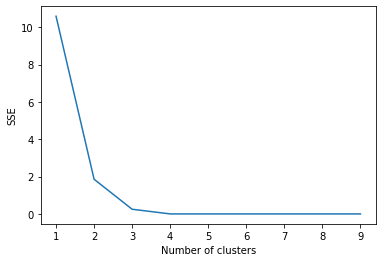

In [194]:
sea_grp_cluster = pets_grp.drop('Neighborhood', axis=1)
sse={}
for q in range(1,10):
    kmeans=KMeans(n_clusters = q, max_iter=1000).fit(sea_grp_cluster)
    sse[q] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

## KMeans CLustering

In [173]:
#set # of clusters
k=3
sea_grp_cluster = pets_grp.drop('Neighborhood', axis=1)

#running the clustering
kmeans= KMeans(n_clusters=k, random_state=0).fit(sea_grp_cluster)

#showing labels
kmeans.labels_[0:3]

array([0, 1, 1])

In [178]:
#pet_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)
sea_merged = seattle_df
#merge seattle_df with sorted venue data
sea_merged = sea_merged.join(pet_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
sea_merged.dropna(inplace=True)
#converting cluster labels to int instead of float
sea_merged['Cluster Labels'] = sea_merged['Cluster Labels'].astype(int)
sea_merged

,Latitude,Longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
2,47.726236,-122.348764,Bitter Lake,1,Pet Store,Pet Service,Dog Run
3,47.694715,-122.371459,Crown Hill,1,Pet Store,Pet Service,Dog Run
4,47.690981,-122.354877,Greenwood,1,Pet Store,Pet Service,Dog Run
5,47.713153,-122.321231,Northgate,3,Pet Service,Dog Run,Pet Store
7,47.603832,-122.330062,Pinehurst,1,Pet Store,Pet Service,Dog Run
9,47.719162,-122.295494,Lake City,0,Dog Run,Pet Store,Pet Service
18,47.677305,-122.313807,Roosevelt,1,Pet Store,Pet Service,Dog Run
25,47.662740,-122.298925,University Village,1,Pet Store,Pet Service,Dog Run
26,47.659463,-122.334342,Wallingford,1,Pet Store,Pet Service,Dog Run
27,47.654379,-122.320897,Northlake,1,Pet Store,Pet Service,Dog Run


# Visualize resultant clusters

In [179]:
cluster_map = folium.Map(location = [sea_latitude, sea_longitude], zoom_start=11)
#settign color scheme for clusters
x=np.arange(k)
colors_array = cm.rainbow(np.linspace(0,1,k))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#adding markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sea_merged['Latitude'],sea_merged['Longitude'],sea_merged['Neighborhood'],sea_merged['Cluster Labels']):
    label=folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat,lon],
    radius=5,
    popup=label,
    color=rainbow[cluster-1],
    fill=True,
    fill_color=rainbow[cluster-1],
    fill_opacity=0.6).add_to(cluster_map)

cluster_map

# Results/ Discussion

The results from this project are that due to the density and proximity of pet related venues in all of the seattle proper neighborhoods, downtown Seattle is a good place to live if planning to live with a dog. There are many pet related shops in this area and many non-pet related venues are also pet-friendly. 

At the start of this project, there were 127 neighborhoods obtained from the wikipedia datasource. It was quickly found that there are not many datasources on the geolocation data for the neighborhoods in Seattle like there are for other large cities. The neighborhoods dataset needed substantial manipulation to get the geopy service to work properly and was still unable to locate all of the neighborhoods properly, which led to a smaller resultant datset. 

# Conclusion

In conclusion, based on the clustering of pet related venues on Seattle neighborhoods, downtown Seattle is a good place to choose for dog ownership and the Capitol Hill and University District neighborhoods follow as good places to live as well. Pets can be an important part of our lives and living in close proximity to resources for them can offer convenience and selection. Thank you!